In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torchinfo import summary

In [2]:
from torchvision import transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, random_split

In [3]:
train_df = pd.read_csv("/kaggle/input/ml-intensive-yandex-academy-spring-2025/human_poses_data/train_answers.csv")
train_df

,img_id,target_feature
0,17363,2
1,8612,5
2,8244,0
3,9264,0
4,5382,6
...,...,...
12362,11503,4
12363,12201,6
12364,5489,3
12365,883,5


In [4]:
train_df["target_feature"].value_counts(normalize=True) 
# Видим, что в исходных данных всего 16 типов данных, а не 20, как в справочнике - потом надо переделать модель на 16 классов
# Потом можно добавить график

target_feature
0     0.203121
3     0.135845
9     0.098892
5     0.079405
6     0.064688
16    0.060888
4     0.060807
8     0.043099
2     0.042856
11    0.042694
12    0.037924
13    0.035740
18    0.033153
10    0.031536
14    0.018436
1     0.010916
Name: proportion, dtype: float64

In [5]:
# Если делать модель на 20 классах, 
# то на одних и тех же данных то метрика на валидации будет отличаться от метрики на нашей валидации.
# Например у нас f1 0.39, а на лидерборде около 0.5. Если классов сделать 16 (как на самом деле есть), 
# то на этих же предсказаниях метрика будет уже 0.49 (f1 чуствительна к количеству классов)
# Самое просто это перекодировать классы. Например (просто берем по уменьшении доли класс)

target_feature_to_class_id = {
    0:0,
    3:1,
    9:2,
    5:3,
    6:4,
    16:5,
    4:6,
    8:7,
    2:8,
    11:9,
    12:10,
    13:11,
    18:12,
    10:13,
    14:14,
    1:15,
}

class_id_to_target_feature = {v:k for k,v in target_feature_to_class_id.items()}

print(f'target_feature -> class_id', target_feature_to_class_id)
print(f'class_id -> target_feature', class_id_to_target_feature)

target_feature -> class_id {0: 0, 3: 1, 9: 2, 5: 3, 6: 4, 16: 5, 4: 6, 8: 7, 2: 8, 11: 9, 12: 10, 13: 11, 18: 12, 10: 13, 14: 14, 1: 15}
class_id -> target_feature {0: 0, 1: 3, 2: 9, 3: 5, 4: 6, 5: 16, 6: 4, 7: 8, 8: 2, 9: 11, 10: 12, 11: 13, 12: 18, 13: 10, 14: 14, 15: 1}


In [6]:
# Заменим 20 классов на новые идентификатры 16 классов
train_df['target_feature'] = train_df['target_feature'].replace(target_feature_to_class_id)
train_df

,img_id,target_feature
0,17363,8
1,8612,3
2,8244,0
3,9264,0
4,5382,4
...,...,...
12362,11503,6
12363,12201,4
12364,5489,1
12365,883,3


In [7]:
# Разделим данные на train и valid сохранением доли таргета
train_df, valid_df = train_test_split(train_df, train_size=0.8, random_state=5, shuffle=True, stratify=train_df["target_feature"])

In [8]:
# Проверим, что доли таргета не поменялись. Потом можно добавить график
print(train_df["target_feature"].value_counts(normalize=True))
print(valid_df["target_feature"].value_counts(normalize=True))

target_feature
0     0.203174
1     0.135854
2     0.098858
3     0.079450
4     0.064692
5     0.060851
6     0.060851
7     0.043061
8     0.042859
9     0.042656
10    0.037906
11    0.035783
12    0.033155
13    0.031537
14    0.018397
15    0.010917
Name: proportion, dtype: float64
target_feature
0     0.202910
1     0.135812
2     0.099030
3     0.079224
4     0.064673
5     0.061035
6     0.060631
7     0.043250
8     0.042846
9     0.042846
10    0.037995
11    0.035570
12    0.033145
13    0.031528
14    0.018593
15    0.010914
Name: proportion, dtype: float64


In [9]:
# train_df = train_df.head(300)
# valid_df = valid_df.head(300)

In [10]:
# Класс для загрузки картинок и информации о них
class ImageDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.data = df
        self.img_dir = img_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = str(self.data.iloc[idx]['img_id']) + ".jpg" 
        img_path = os.path.join(self.img_dir, img_name)
        
        # Читаем изображение
        image = read_image(img_path)
        
        # Получаем метку из CSV
        label = self.data.iloc[idx]['target_feature']
        
        # Применяем трансформации, если они заданы
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [11]:
# Класс для загрузки картинок и информации о них
class ImageDatasetCached(Dataset):
    def __init__(self, df, img_dir, transform_disk=None, transform_mem=None):
        self.data = df
        self.img_dir = img_dir
        self.transform_disk = transform_disk
        self.transform_mem = transform_mem

        print("Читаем даннные в память")
        self.cache_list = []
        for idx in tqdm(range(len(self.data))):
            item = self.get_item_from_disk(idx)
            self.cache_list.append(item)

    def get_item_from_disk(self, idx):
        img_name = str(self.data.iloc[idx]['img_id']) + ".jpg"
        img_path = os.path.join(self.img_dir, img_name)

        # Читаем изображение
        image = read_image(img_path)

        # Получаем метку из CSV
        label = self.data.iloc[idx]['target_feature']

        # Применяем трансформации, если они заданы
        if self.transform_disk:
            image = self.transform_disk(image)

        return image, label

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.cache_list[idx]

        # Применяем трансформации, если они заданы
        if self.transform_mem:
            image = self.transform_mem(image)

        return image, label


In [12]:
import torchvision.transforms.v2 as v2
from tqdm import tqdm
# https://pytorch.org/vision/stable/transforms.html

transform_train_disk = v2.Compose([
    v2.Resize(256),
])

transform_train_mem = v2.Compose([
    # 1) Случайная обрезка + масштабирование
    v2.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.75, 1.33)),

    # 2) Флип и поворот
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=10),

    # 3) Цветовые аугментации
    v2.RandomApply([v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05)], p=0.8),
    v2.RandomGrayscale(p=0.1),


    # 4) Случайная перспектива и размытие
    v2.RandomPerspective(distortion_scale=0.2, p=0.3),
    v2.RandomApply([v2.GaussianBlur(kernel_size=3)], p=0.3),

    # 5) Случайное стирание блоков
    v2.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3)),

    # 6) Преобразование типа к float32
    v2.ToDtype(torch.float32, scale=True),

    # 6) Нормализация
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std =[0.229, 0.224, 0.225]),
])

transform_valid_disk = v2.Compose([
    v2.Resize(224),
    v2.CenterCrop(224),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_valid_mem = None

train_dataset = ImageDatasetCached(
    df=train_df,
    img_dir='/kaggle/input/ml-intensive-yandex-academy-spring-2025/human_poses_data/img_train',
    transform_disk=transform_train_disk,
    transform_mem=transform_train_mem,
)

valid_dataset = ImageDatasetCached(
    df=valid_df,
    img_dir='/kaggle/input/ml-intensive-yandex-academy-spring-2025/human_poses_data/img_train',
    transform_disk=transform_valid_disk,
)

Читаем даннные в память


100%|██████████| 9893/9893 [04:33<00:00, 36.14it/s]


Читаем даннные в память


100%|██████████| 2474/2474 [01:07<00:00, 36.45it/s]


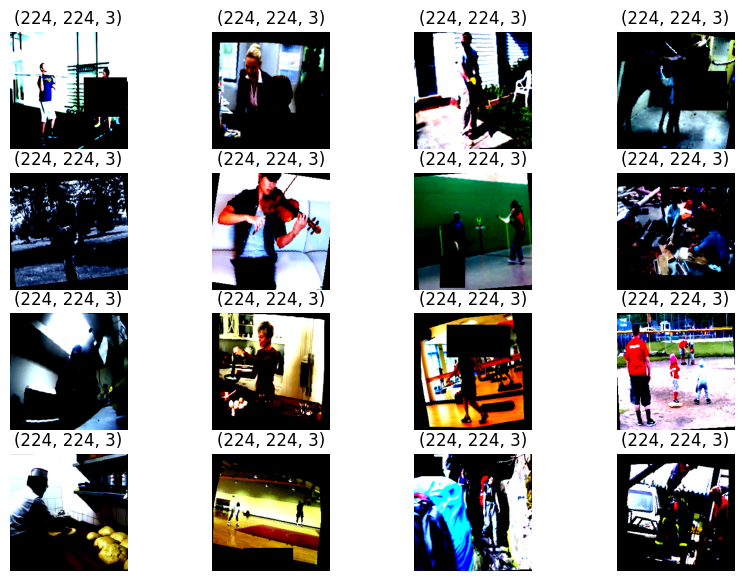

In [13]:
plt.figure(figsize=(10, 7))
for i in range(16):
    plt.subplot(4, 4, i+1)
    img, label = train_dataset[i]
    img = img.permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.axis('off') 
    plt.title(f"{img.shape}")

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Функции создания моделей

In [15]:
# Сделаем модель с skip-conection
def create_resnet18_model(dropout_conv = 0.1, dropout_linear = 0.5, max_drop_path_rate=0.2):

    class DropPath(nn.Module):
        def __init__(self, drop_prob=0.0):
            super().__init__()
            self.drop_prob = drop_prob

        def forward(self, x):
            if self.drop_prob == 0. or not self.training:
                return x
            keep_prob = 1 - self.drop_prob
            shape = (x.shape[0],) + (1,) * (x.ndim - 1)
            random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
            random_tensor.floor_()
            return x.div(keep_prob) * random_tensor

    class ResidualBlock(nn.Module):
        def __init__(self, in_channels, out_channels, stride, drop_path_prob=0.1):
            super().__init__()

            self.main = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.1),
                # nn.Dropout2d(dropout_conv),

                nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.1),
                nn.Dropout2d(dropout_conv),
            )

            self.skip = nn.Identity() if in_channels == out_channels and stride == 1 else nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(out_channels),
            )

            self.drop_path = DropPath(drop_prob=drop_path_prob)
            self.final_relu = nn.LeakyReLU(0.1)

        def forward(self, x):
            x = self.drop_path(self.main(x)) + self.skip(x)
            x = self.final_relu(x)
            return x


    drop_path_rate = [x.item() for x in torch.linspace(0, max_drop_path_rate, 8)]  # 8 blocks total
    channels = 64

    model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=channels, kernel_size=7, stride=2, padding=3, bias=False),
        nn.BatchNorm2d(channels),
        nn.LeakyReLU(0.1),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

        ResidualBlock(in_channels=channels, out_channels=channels, stride=1, drop_path_prob=drop_path_rate[0]),
        ResidualBlock(in_channels=channels, out_channels=channels, stride=1, drop_path_prob=drop_path_rate[1]),

        ResidualBlock(in_channels=channels, out_channels=channels*2, stride=2, drop_path_prob=drop_path_rate[2]),
        ResidualBlock(in_channels=channels*2, out_channels=channels*2, stride=1, drop_path_prob=drop_path_rate[3]),

        ResidualBlock(in_channels=channels*2, out_channels=channels*4, stride=2, drop_path_prob=drop_path_rate[4]),
        ResidualBlock(in_channels=channels*4, out_channels=channels*4, stride=1, drop_path_prob=drop_path_rate[5]),

        ResidualBlock(in_channels=channels*4, out_channels=channels*8, stride=2, drop_path_prob=drop_path_rate[6]),
        ResidualBlock(in_channels=channels*8, out_channels=channels*8, stride=1, drop_path_prob=drop_path_rate[7]),

        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
        nn.Dropout(dropout_linear),
        nn.Linear(in_features=channels*8, out_features=16),
    )

    print(summary(model, input_size=(128, 3, 224, 224), col_names=["input_size", "output_size", "num_params"], depth=3))
    return model

create_resnet18_model()

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Sequential                               [128, 3, 224, 224]        [128, 16]                 --
├─Conv2d: 1-1                            [128, 3, 224, 224]        [128, 64, 112, 112]       9,408
├─BatchNorm2d: 1-2                       [128, 64, 112, 112]       [128, 64, 112, 112]       128
├─LeakyReLU: 1-3                         [128, 64, 112, 112]       [128, 64, 112, 112]       --
├─MaxPool2d: 1-4                         [128, 64, 112, 112]       [128, 64, 56, 56]         --
├─ResidualBlock: 1-5                     [128, 64, 56, 56]         [128, 64, 56, 56]         --
│    └─Sequential: 2-1                   [128, 64, 56, 56]         [128, 64, 56, 56]         --
│    │    └─Conv2d: 3-1                  [128, 64, 56, 56]         [128, 64, 56, 56]         36,864
│    │    └─BatchNorm2d: 3-2             [128, 64, 56, 56]         [128, 64, 56, 56]         128
│    │    └─LeakyReLU: 3-3

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.1)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): ResidualBlock(
    (main): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.1)
      (6): Dropout2d(p=0.1, inplace=False)
    )
    (skip): Identity()
    (drop_path): DropPath()
    (final_relu): LeakyReLU(negative_slope=0.1)
  )
  (5): ResidualBlock(
    (main): Sequential(
      (0): C

# Вспомогательные функции (обучение/предсказание/графики)

In [16]:
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.handlers import EarlyStopping, ModelCheckpoint
from ignite.contrib.handlers import ProgressBar
from ignite.metrics import Loss, Accuracy, Average, RunningAverage, Precision, Recall, Fbeta
from ignite.utils import convert_tensor

/usr/local/lib/python3.10/dist-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [17]:
def train_model(model,
                loss_fn,
                optimizer,
                train_dataloader,
                valid_dataloader,
                max_epoch,
                device,
                validation_patience=5,
                validation_lr_reduce_patience=2,
                checkpoints_name_prefix='baseline',
                checkpoints_n_saved=3,
               ):
    # Создание trainer
    train_engine = create_supervised_trainer(
        model=model,
        optimizer=optimizer,
        loss_fn=loss_fn,
        device=device,
        output_transform=lambda x, y, y_pred, loss: (loss.item(), y_pred, y)
    )

    # Добавляем метрики для подсчета train_loss
    train_loss = Average(output_transform=lambda x: x[0])
    train_loss.attach(train_engine, 'train_loss')

    # Создаем метрики Precision и Recall
    P = Precision(average=False, output_transform=lambda x: (x[1], x[2]))
    R = Recall(average=False, output_transform=lambda x: (x[1], x[2]))

    # Создаем F1-метрику (Fbeta с beta=1)
    train_metric = Fbeta(beta=1.0, precision=P, recall=R)
    train_metric.attach(train_engine, "train_f1")

    # Создание Engine для валидации
    valid_engine = create_supervised_evaluator(
        model=model,
        device=device,
        output_transform=lambda x, y, y_pred: (loss_fn(input=y_pred, target=y).item(), y_pred, y)
    )

    # Добавляем метрики для подсчета valid_loss
    valid_loss = Average(output_transform=lambda x: x[0])
    valid_loss.attach(valid_engine, 'valid_loss')

    # Создаем метрики Precision и Recall для валидации
    P = Precision(average=False, output_transform=lambda x: (x[1], x[2]))
    R = Recall(average=False, output_transform=lambda x: (x[1], x[2]))

    # Создаем F1-метрику (Fbeta с beta=1)
    valid_metric = Fbeta(beta=1.0, precision=P, recall=R)
    valid_metric.attach(valid_engine, "valid_f1")

    train_loss_history = []
    train_f1_history = []
    valid_loss_history = []
    valid_f1_history = []

    # Создаем scheduler ReduceLROnPlateau
    reducelr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,       # Наш оптимизатор
        mode="max",      # Мы хотим максимизировать f1
        factor=0.5,      # Во сколько раз уменьшать lr
        patience=validation_lr_reduce_patience, # Сколько эпох ждать
        threshold=1e-5,  # Минимальное улучшение
        cooldown=0,      # Эпох после снижения
        min_lr=1e-6,     # Минимальный lr
    )

    # После каждой эпохи train_engine должен запускать valid_engine
    def compute_epoch_results(engine):
        valid_engine.run(valid_dataloader, epoch_length=None)
        train_loss = engine.state.metrics['train_loss']
        train_f1 = engine.state.metrics['train_f1']
        valid_loss = valid_engine.state.metrics['valid_loss']
        valid_f1 = valid_engine.state.metrics['valid_f1']

        train_loss_history.append(train_loss)
        train_f1_history.append(train_f1)
        valid_loss_history.append(valid_loss)
        valid_f1_history.append(valid_f1)

        print(f"Эпоха: {engine.state.epoch} "
              f"train_loss: {train_loss:.4f} valid_loss: {valid_loss:.4f} "
              f"train_f1: {train_f1:.4f} valid_f1: {valid_f1:.4f} "
              f"lr: {reducelr_scheduler.get_last_lr()[0]}")

        # Обновляем lr по valid_f1
        reducelr_scheduler.step(valid_f1)

    train_engine.add_event_handler(Events.EPOCH_COMPLETED, compute_epoch_results)

    # Добавляем EarlyStopping
    early_stop_handler = EarlyStopping(
        patience=validation_patience,
        score_function=lambda engine: valid_engine.state.metrics['valid_f1'],
        trainer=train_engine
    )
    train_engine.add_event_handler(Events.EPOCH_COMPLETED, early_stop_handler)

    # Сохранение лучших моделей с номером эпохи и значением valid_f1 в имени файла
    checkpointer = ModelCheckpoint(
        dirname="models",
        filename_prefix=checkpoints_name_prefix,
        n_saved=checkpoints_n_saved,
        create_dir=True,
        require_empty=False,
        score_function=lambda engine: valid_engine.state.metrics['valid_f1'],
        score_name="valid_f1",
        global_step_transform=lambda engine, _: engine.state.epoch
    )
    train_engine.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {'model': model})

    # Прогресс-бар
    progress_bar = ProgressBar()
    progress_bar.attach(train_engine)

    # Запуск обучения
    engine_output = train_engine.run(train_dataloader,
                                     max_epochs=max_epoch,
                                     epoch_length=None)

    # Возвращаем историю
    return {
        "train_loss_history": train_loss_history,
        "valid_loss_history": valid_loss_history,
        "train_f1_history": train_f1_history,
        "valid_f1_history": valid_f1_history,
        'checkpointer': checkpointer
    }


In [18]:
def predict_model_score(model, dataloader, device):
    test_engine = create_supervised_evaluator(
        model=model,
        device=device,
        output_transform=lambda x, y, y_pred: y_pred
    )

    pred_list = []

    def compute_epoch_results(engine):
        pred_list.append(engine.state.output.cpu().numpy())

    test_engine.add_event_handler(Events.ITERATION_COMPLETED, compute_epoch_results)

    # Создаем прогресс-бар
    progress_bar = ProgressBar()

    # Привязываем к trainer
    progress_bar.attach(test_engine)

    # Запускаем предсказание
    test_engine_output = test_engine.run(dataloader)

    # Объединяем предсказания в разных batch
    pred = np.concatenate(pred_list)
    print(pred.shape)

    return pred

def predict_model(model, dataloader, device):
    pred = predict_model_score(model, dataloader, device)

    # Максимум это предсказанный класс
    pred = pred.argmax(1)
    print(pred.shape)

    return pred

In [19]:
def plot_train_history(train_loss_history, valid_loss_history, train_f1_history, valid_f1_history):
    plt.plot(range(len(train_loss_history)), train_loss_history, label="train_loss")
    plt.plot(range(len(valid_loss_history)), valid_loss_history, label="valid_loss")
    
    best_epoch = np.argmax(np.array(valid_f1_history))
    plt.axvline(x=best_epoch, color='red', label="best valid_f1 epoch")
    
    plt.legend()
    plt.show()
    
    plt.plot(range(len(train_f1_history)), train_f1_history, label="train_f1")
    plt.plot(range(len(valid_f1_history)), valid_f1_history, label="valid_f1")
    
    plt.axvline(x=best_epoch, color='red', label="best valid_f1 epoch")
    
    plt.legend()
    plt.show()

def plot_train_history_from_results(train_results):
    plot_train_history(
        train_results['train_loss_history'],
        train_results['valid_loss_history'],
        train_results['train_f1_history'],
        train_results['valid_f1_history'],
    )

In [20]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, class_names=None):
    cm = confusion_matrix(y_true, y_pred)
    num_classes = cm.shape[0]

    if class_names is None:
        class_names = [str(i) for i in range(num_classes)]

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

# Основной код обучения

In [21]:
# У нас доли классов разные. А метрика f1-macro, которая усредняется по классам.
# Т.е. класс с маленькой долей влияет так же как и класс с большой долей.
# Укажим явно веса классов

from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['target_feature'].values),  # targets — массив меток (например, из train.csv)
    y=train_df['target_feature'].values
)
print(class_weights)

[0.30761816 0.46005394 0.63222137 0.78665712 0.96611328 1.02709718
 1.02709718 1.45143779 1.4582842  1.4651955  1.64883333 1.74664548
 1.88509909 1.98177083 3.39732143 5.72511574]


In [22]:
# Создаем модель
model = create_resnet18_model()
model = model.to(device)

# Создаем loss функцию
loss_fn = nn.CrossEntropyLoss(
    weight=torch.tensor(class_weights, dtype=torch.float32).to(device),
    label_smoothing = 0.1,
)

# Создаем оптимизатор, который будет обновлять веса модели с указаным lr. Зададим weight_decay, который будет стараться минимизировать веса модели
optimizer = torch.optim.AdamW(params=model.parameters(), lr=0.001, weight_decay=5e-4)

# Создаем даталоадеры с данными в батчах
batch_size = 256

# У нас не очень много данных, но мы хотим batch 256 так что увеличим датасет в 4 раза чтобы было достаточно итераций 
from torch.utils.data import ConcatDataset
train_dataset_long = ConcatDataset([train_dataset, train_dataset, train_dataset, train_dataset])
train_dataloader = DataLoader(train_dataset_long, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Запускаем обучение модели
train_results = train_model(
    model=model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    max_epoch = 100,
    validation_patience = 5,
    validation_lr_reduce_patience=2,
    checkpoints_name_prefix='resnet18',
    checkpoints_n_saved=10,
    device=device,
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Sequential                               [128, 3, 224, 224]        [128, 16]                 --
├─Conv2d: 1-1                            [128, 3, 224, 224]        [128, 64, 112, 112]       9,408
├─BatchNorm2d: 1-2                       [128, 64, 112, 112]       [128, 64, 112, 112]       128
├─LeakyReLU: 1-3                         [128, 64, 112, 112]       [128, 64, 112, 112]       --
├─MaxPool2d: 1-4                         [128, 64, 112, 112]       [128, 64, 56, 56]         --
├─ResidualBlock: 1-5                     [128, 64, 56, 56]         [128, 64, 56, 56]         --
│    └─Sequential: 2-1                   [128, 64, 56, 56]         [128, 64, 56, 56]         --
│    │    └─Conv2d: 3-1                  [128, 64, 56, 56]         [128, 64, 56, 56]         36,864
│    │    └─BatchNorm2d: 3-2             [128, 64, 56, 56]         [128, 64, 56, 56]         128
│    │    └─LeakyReLU: 3-3

/usr/local/lib/python3.10/dist-packages/ignite/handlers/tqdm_logger.py:127: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


[1/155]   1%|           [00:00<?]

Эпоха: 1 train_loss: 2.8582 valid_loss: 2.6829 train_f1: 0.1076 valid_f1: 0.1367 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 2 train_loss: 2.7071 valid_loss: 2.6116 train_f1: 0.1574 valid_f1: 0.2149 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 3 train_loss: 2.6333 valid_loss: 2.5583 train_f1: 0.1801 valid_f1: 0.1975 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 4 train_loss: 2.5695 valid_loss: 2.5061 train_f1: 0.2002 valid_f1: 0.2255 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 5 train_loss: 2.5166 valid_loss: 2.4391 train_f1: 0.2220 valid_f1: 0.2491 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 6 train_loss: 2.4657 valid_loss: 2.4138 train_f1: 0.2401 valid_f1: 0.2480 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 7 train_loss: 2.4262 valid_loss: 2.3404 train_f1: 0.2568 valid_f1: 0.2769 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 8 train_loss: 2.3909 valid_loss: 2.4154 train_f1: 0.2719 valid_f1: 0.2497 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 9 train_loss: 2.3624 valid_loss: 2.3990 train_f1: 0.2816 valid_f1: 0.2853 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 10 train_loss: 2.3065 valid_loss: 2.3376 train_f1: 0.3022 valid_f1: 0.3300 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 11 train_loss: 2.2749 valid_loss: 2.3051 train_f1: 0.3140 valid_f1: 0.3378 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 12 train_loss: 2.2333 valid_loss: 2.2361 train_f1: 0.3293 valid_f1: 0.3576 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 13 train_loss: 2.1982 valid_loss: 2.3380 train_f1: 0.3482 valid_f1: 0.3203 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 14 train_loss: 2.1476 valid_loss: 2.2446 train_f1: 0.3661 valid_f1: 0.3696 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 15 train_loss: 2.1158 valid_loss: 2.1524 train_f1: 0.3801 valid_f1: 0.3964 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 16 train_loss: 2.0749 valid_loss: 2.2232 train_f1: 0.3951 valid_f1: 0.3840 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 17 train_loss: 2.0310 valid_loss: 2.1382 train_f1: 0.4127 valid_f1: 0.4041 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 18 train_loss: 1.9915 valid_loss: 2.0098 train_f1: 0.4312 valid_f1: 0.4421 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 19 train_loss: 1.9518 valid_loss: 2.0557 train_f1: 0.4458 valid_f1: 0.4502 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 20 train_loss: 1.9119 valid_loss: 2.0289 train_f1: 0.4646 valid_f1: 0.4444 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 21 train_loss: 1.8687 valid_loss: 2.0813 train_f1: 0.4837 valid_f1: 0.4594 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 22 train_loss: 1.8224 valid_loss: 1.9793 train_f1: 0.5013 valid_f1: 0.4747 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 23 train_loss: 1.7761 valid_loss: 2.0358 train_f1: 0.5227 valid_f1: 0.4779 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 24 train_loss: 1.7640 valid_loss: 1.9454 train_f1: 0.5300 valid_f1: 0.4992 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 25 train_loss: 1.7160 valid_loss: 1.9083 train_f1: 0.5527 valid_f1: 0.5033 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 26 train_loss: 1.6730 valid_loss: 2.0167 train_f1: 0.5758 valid_f1: 0.5009 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 27 train_loss: 1.6426 valid_loss: 1.8934 train_f1: 0.5883 valid_f1: 0.5438 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 28 train_loss: 1.6146 valid_loss: 2.0329 train_f1: 0.6028 valid_f1: 0.5274 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 29 train_loss: 1.5943 valid_loss: 1.8563 train_f1: 0.6133 valid_f1: 0.5716 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 30 train_loss: 1.5584 valid_loss: 1.8773 train_f1: 0.6326 valid_f1: 0.5650 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 31 train_loss: 1.5258 valid_loss: 1.9158 train_f1: 0.6440 valid_f1: 0.5637 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 32 train_loss: 1.4862 valid_loss: 1.9081 train_f1: 0.6672 valid_f1: 0.5697 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 33 train_loss: 1.4155 valid_loss: 1.7305 train_f1: 0.6990 valid_f1: 0.5957 lr: 0.0005


[1/155]   1%|           [00:00<?]

Эпоха: 34 train_loss: 1.3861 valid_loss: 1.7259 train_f1: 0.7166 valid_f1: 0.6145 lr: 0.0005


[1/155]   1%|           [00:00<?]

Эпоха: 35 train_loss: 1.3562 valid_loss: 1.7864 train_f1: 0.7329 valid_f1: 0.6240 lr: 0.0005


[1/155]   1%|           [00:00<?]

Эпоха: 36 train_loss: 1.3422 valid_loss: 1.7443 train_f1: 0.7434 valid_f1: 0.6336 lr: 0.0005


[1/155]   1%|           [00:00<?]

Эпоха: 37 train_loss: 1.3396 valid_loss: 1.7594 train_f1: 0.7407 valid_f1: 0.6268 lr: 0.0005


[1/155]   1%|           [00:00<?]

Эпоха: 38 train_loss: 1.3132 valid_loss: 1.7744 train_f1: 0.7572 valid_f1: 0.6404 lr: 0.0005


[1/155]   1%|           [00:00<?]

Эпоха: 39 train_loss: 1.2999 valid_loss: 1.7746 train_f1: 0.7616 valid_f1: 0.6389 lr: 0.0005


[1/155]   1%|           [00:00<?]

Эпоха: 40 train_loss: 1.2950 valid_loss: 1.7144 train_f1: 0.7675 valid_f1: 0.6468 lr: 0.0005


[1/155]   1%|           [00:00<?]

Эпоха: 41 train_loss: 1.2844 valid_loss: 1.7450 train_f1: 0.7770 valid_f1: 0.6311 lr: 0.0005


[1/155]   1%|           [00:00<?]

Эпоха: 42 train_loss: 1.2735 valid_loss: 1.7373 train_f1: 0.7773 valid_f1: 0.6423 lr: 0.0005


[1/155]   1%|           [00:00<?]

Эпоха: 43 train_loss: 1.2605 valid_loss: 1.7083 train_f1: 0.7859 valid_f1: 0.6527 lr: 0.0005


[1/155]   1%|           [00:00<?]

Эпоха: 44 train_loss: 1.2514 valid_loss: 1.7196 train_f1: 0.7933 valid_f1: 0.6326 lr: 0.0005


[1/155]   1%|           [00:00<?]

Эпоха: 45 train_loss: 1.2459 valid_loss: 1.7036 train_f1: 0.7951 valid_f1: 0.6577 lr: 0.0005


[1/155]   1%|           [00:00<?]

Эпоха: 46 train_loss: 1.2348 valid_loss: 1.7133 train_f1: 0.8020 valid_f1: 0.6369 lr: 0.0005


[1/155]   1%|           [00:00<?]

Эпоха: 47 train_loss: 1.2308 valid_loss: 1.7362 train_f1: 0.8045 valid_f1: 0.6495 lr: 0.0005


[1/155]   1%|           [00:00<?]

Эпоха: 48 train_loss: 1.2215 valid_loss: 1.7253 train_f1: 0.8071 valid_f1: 0.6457 lr: 0.0005


[1/155]   1%|           [00:00<?]

Эпоха: 49 train_loss: 1.1946 valid_loss: 1.6435 train_f1: 0.8240 valid_f1: 0.6762 lr: 0.00025


[1/155]   1%|           [00:00<?]

Эпоха: 50 train_loss: 1.1753 valid_loss: 1.6421 train_f1: 0.8331 valid_f1: 0.6742 lr: 0.00025


[1/155]   1%|           [00:00<?]

Эпоха: 51 train_loss: 1.1745 valid_loss: 1.6736 train_f1: 0.8349 valid_f1: 0.6542 lr: 0.00025


[1/155]   1%|           [00:00<?]

Эпоха: 52 train_loss: 1.1649 valid_loss: 1.6595 train_f1: 0.8392 valid_f1: 0.6692 lr: 0.00025


[1/155]   1%|           [00:00<?]

Эпоха: 53 train_loss: 1.1498 valid_loss: 1.6249 train_f1: 0.8495 valid_f1: 0.6748 lr: 0.000125


[1/155]   1%|           [00:00<?]

2025-04-19 09:12:45,012 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Эпоха: 54 train_loss: 1.1450 valid_loss: 1.6377 train_f1: 0.8511 valid_f1: 0.6632 lr: 0.000125


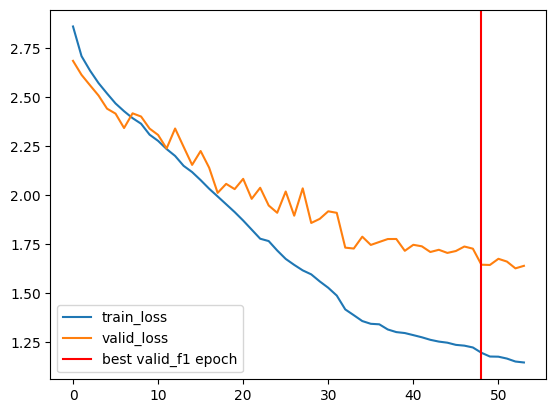

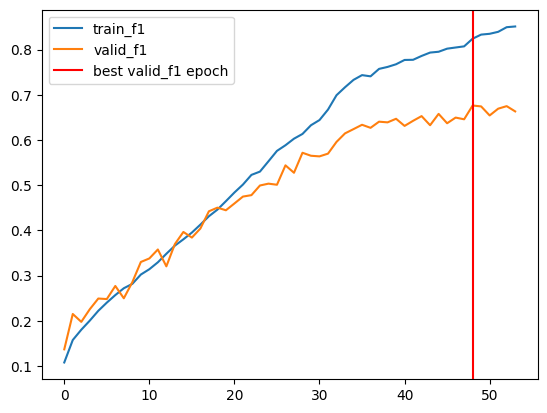

In [23]:
plot_train_history_from_results(train_results)

[1/10]  10%|#          [00:00<?]

(2474, 16)
(2474,)
              precision    recall  f1-score   support

           0      0.801     0.745     0.772       502
           1      0.725     0.565     0.635       336
           2      0.854     0.837     0.845       245
           3      0.591     0.663     0.625       196
           4      0.746     0.806     0.775       160
           5      0.498     0.722     0.589       151
           6      0.713     0.747     0.730       150
           7      0.743     0.757     0.750       107
           8      0.657     0.434     0.523       106
           9      0.583     0.792     0.672       106
          10      0.851     0.851     0.851        94
          11      0.600     0.477     0.532        88
          12      0.795     0.805     0.800        82
          13      0.696     0.705     0.701        78
          14      0.596     0.609     0.602        46
          15      0.175     0.259     0.209        27

    accuracy                          0.703      2474
   macr

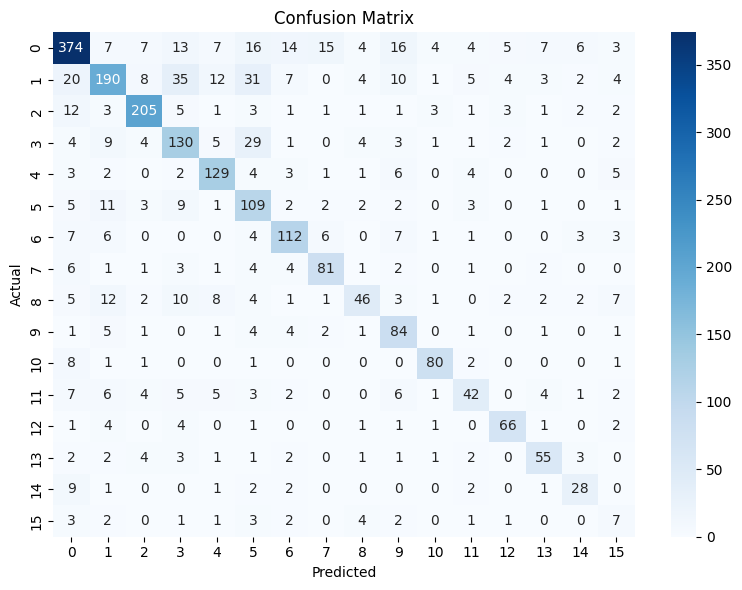

In [24]:
valid_pred = predict_model(model, valid_dataloader, device)
valid_fact = valid_df['target_feature'].values

print(classification_report(valid_fact, valid_pred, digits=3))
plot_confusion_matrix(valid_fact, valid_pred)

# Предсказание

In [25]:
# Соберем pandas DataFrame для тестовых данных и из него сделаем тестовый датасет
file_list = os.listdir('/kaggle/input/ml-intensive-yandex-academy-spring-2025/human_poses_data/img_test')
img_id_list = [int(file_name.split(".")[0]) for file_name in file_list]

In [26]:
test_df = pd.DataFrame({
    "img_id": img_id_list,
    "target_feature": -1
})
# test_df = test_df.head(2)
test_df

,img_id,target_feature
0,16916,-1
1,12666,-1
2,623,-1
3,11925,-1
4,2008,-1
...,...,...
5296,728,-1
5297,1656,-1
5298,3361,-1
5299,2599,-1


In [27]:
test_dataset = ImageDataset(
    df=test_df,
    img_dir="/kaggle/input/ml-intensive-yandex-academy-spring-2025/human_poses_data/img_test",
    transform=transform_valid_disk
)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [28]:
# Предскажем моделью с последней эпохи
test_pred = predict_model(model, test_dataloader, device)

# Сохраним предсказание в таблицу
test_df['target_feature'] = test_pred

# Мы заменяли 20 классов на наши 16 - теперь надо вернуть исходные классы
test_df['target_feature'] = test_df['target_feature'].replace(class_id_to_target_feature)

# В результатах требуется колонка id (маленькими буквами)
test_df["id"] = test_df['img_id']

# Запишим колонки id и target_feature в csv файл. Указываем index=False, чтобы не добавлялась еще одна колонка с индексом
test_df[['id', 'target_feature']].to_csv('result_last.csv', index=False)

[1/21]   5%|4          [00:00<?]

(5301, 16)
(5301,)


In [29]:
# Предскажем моделью с оптимальной эпохи
model_path = train_results['checkpointer'].last_checkpoint
print(f'model_path={model_path}')
model.load_state_dict(torch.load(model_path, weights_only=True, map_location=device))
model = model.to(device)

test_pred = predict_model(model, test_dataloader, device)

# Сохраним предсказание в таблицу
test_df['target_feature'] = test_pred

# Мы заменяли 20 классов на наши 16 - теперь надо вернуть исходные классы
test_df['target_feature'] = test_df['target_feature'].replace(class_id_to_target_feature)

# В результатах требуется колонка id (маленькими буквами)
test_df["id"] = test_df['img_id']

# Запишим колонки id и target_feature в csv файл. Указываем index=False, чтобы не добавлялась еще одна колонка с индексом
test_df[['id', 'target_feature']].to_csv('result_best_1.csv', index=False)

model_path=models/resnet18_model_49_valid_f1=0.6762.pt


[1/21]   5%|4          [00:00<?]

(5301, 16)
(5301,)


In [30]:
# Предскажем средним с трех лучших эпох
model_path_list = [i.filename for i in train_results['checkpointer']._saved[::-1][:3]]
model_path_list = [train_results['checkpointer'].save_handler.dirname / i for i in model_path_list]
test_df_list = []
print(f'Сохраненные версии: {model_path_list}')

test_pred_list = []
for model_path in model_path_list:
    print(f'Предсказываем моделью: {model_path}')
    model.load_state_dict(torch.load(model_path, weights_only=True, map_location=device))
    model = model.to(device)
    
    test_pred = predict_model_score(model, test_dataloader, device)
    test_pred_list.append(test_pred)
    
# Объединим предсказания нескольких моделей
test_pred = np.stack(test_pred_list)
print(test_pred.shape)

# Усредним предсказания 
test_pred = test_pred.mean(axis=0)
print(test_pred.shape)

# Максимум это предсказанный класс
test_pred = test_pred.argmax(1)
print(test_pred.shape)

# Сохраним предсказание в таблицу
test_df['target_feature'] = test_pred
    
# Мы заменяли 20 классов на наши 16 - теперь надо вернуть исходные классы
test_df['target_feature'] = test_df['target_feature'].replace(class_id_to_target_feature)
    
# В результатах требуется колонка id (маленькими буквами)
test_df["id"] = test_df['img_id']

# Запишим колонки id и target_feature в csv файл. Указываем index=False, чтобы не добавлялась еще одна колонка с индексом
test_df[['id', 'target_feature']].to_csv('result_best_3_mean.csv', index=False)

Сохраненные версии: [PosixPath('models/resnet18_model_49_valid_f1=0.6762.pt'), PosixPath('models/resnet18_model_53_valid_f1=0.6748.pt'), PosixPath('models/resnet18_model_50_valid_f1=0.6742.pt')]
Предсказываем моделью: models/resnet18_model_49_valid_f1=0.6762.pt


[1/21]   5%|4          [00:00<?]

(5301, 16)
Предсказываем моделью: models/resnet18_model_53_valid_f1=0.6748.pt


[1/21]   5%|4          [00:00<?]

(5301, 16)
Предсказываем моделью: models/resnet18_model_50_valid_f1=0.6742.pt


[1/21]   5%|4          [00:00<?]

(5301, 16)
(3, 5301, 16)
(5301, 16)
(5301,)


# Доучим модель на полных данных

In [31]:
# Дообучим модель с оптимальной эпохи
model_path = train_results['checkpointer'].last_checkpoint
print(f'model_path={model_path}')
model.load_state_dict(torch.load(model_path, weights_only=True, map_location=device))
model = model.to(device)

# Создаем loss функцию
loss_fn = nn.CrossEntropyLoss(
    weight=torch.tensor(class_weights, dtype=torch.float32).to(device),
    label_smoothing = 0.1,
)

# Создаем оптимизатор, который будет обновлять веса модели с указаным lr. Зададим weight_decay, который будет стараться минимизировать веса модели
optimizer = torch.optim.AdamW(params=model.parameters(), lr=0.0001, weight_decay=5e-4)

# Создаем даталоадеры с данными в батчах
batch_size = 256

# Полные данные
train_dataset = ImageDataset(
    df=train_df,
    img_dir='/kaggle/input/ml-intensive-yandex-academy-spring-2025/human_poses_data/img_train',
    transform=transform_valid_disk,
)

valid_dataset = ImageDataset(
    df=valid_df,
    img_dir='/kaggle/input/ml-intensive-yandex-academy-spring-2025/human_poses_data/img_train',
    transform=transform_valid_disk,
)

from torch.utils.data import ConcatDataset
train_dataset_long = ConcatDataset([train_dataset, valid_dataset])
train_dataloader = DataLoader(train_dataset_long, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

# Запускаем обучение модели
train_results2 = train_model(
    model=model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader, # Не будем его реально смотреть
    max_epoch = 2,
    validation_patience = 5,
    validation_lr_reduce_patience=2,
    checkpoints_name_prefix='resnet18_full',
    checkpoints_n_saved=10,
    device=device,
)

model_path=models/resnet18_model_49_valid_f1=0.6762.pt


[1/49]   2%|2          [00:00<?]

Эпоха: 1 train_loss: 1.2796 valid_loss: 1.5081 train_f1: 0.7910 valid_f1: 0.6985 lr: 0.0001


[1/49]   2%|2          [00:00<?]

Эпоха: 2 train_loss: 1.2265 valid_loss: 1.4441 train_f1: 0.8166 valid_f1: 0.7341 lr: 0.0001


In [32]:
# Предскажем со второй лучшей эпохи (будет первая)
model_path_list = [i.filename for i in train_results2['checkpointer']._saved[::-1][1:2]]
model_path_list = [train_results2['checkpointer'].save_handler.dirname / i for i in model_path_list]
test_df_list = []
print(f'Сохраненные версии: {model_path_list}')

test_pred_list = []
for model_path in model_path_list:
    print(f'Предсказываем моделью: {model_path}')
    model.load_state_dict(torch.load(model_path, weights_only=True, map_location=device))
    model = model.to(device)
    
    test_pred = predict_model_score(model, test_dataloader, device)
    test_pred_list.append(test_pred)
    
# Объединим предсказания нескольких моделей
test_pred = np.stack(test_pred_list)
print(test_pred.shape)

# Усредним предсказания 
test_pred = test_pred.mean(axis=0)
print(test_pred.shape)

# Максимум это предсказанный класс
test_pred = test_pred.argmax(1)
print(test_pred.shape)

# Сохраним предсказание в таблицу
test_df['target_feature'] = test_pred
    
# Мы заменяли 20 классов на наши 16 - теперь надо вернуть исходные классы
test_df['target_feature'] = test_df['target_feature'].replace(class_id_to_target_feature)
    
# В результатах требуется колонка id (маленькими буквами)
test_df["id"] = test_df['img_id']

# Запишим колонки id и target_feature в csv файл. Указываем index=False, чтобы не добавлялась еще одна колонка с индексом
test_df[['id', 'target_feature']].to_csv('result_step2_epoch1.csv', index=False)

Сохраненные версии: [PosixPath('models/resnet18_full_model_1_valid_f1=0.6985.pt')]
Предсказываем моделью: models/resnet18_full_model_1_valid_f1=0.6985.pt


[1/21]   5%|4          [00:00<?]

(5301, 16)
(1, 5301, 16)
(5301, 16)
(5301,)


In [33]:
# Предскажем c лучшей эпохи (будет вторая)
model_path_list = [i.filename for i in train_results2['checkpointer']._saved[::-1][0:1]]
model_path_list = [train_results2['checkpointer'].save_handler.dirname / i for i in model_path_list]
test_df_list = []
print(f'Сохраненные версии: {model_path_list}')

test_pred_list = []
for model_path in model_path_list:
    print(f'Предсказываем моделью: {model_path}')
    model.load_state_dict(torch.load(model_path, weights_only=True, map_location=device))
    model = model.to(device)
    
    test_pred = predict_model_score(model, test_dataloader, device)
    test_pred_list.append(test_pred)
    
# Объединим предсказания нескольких моделей
test_pred = np.stack(test_pred_list)
print(test_pred.shape)

# Усредним предсказания 
test_pred = test_pred.mean(axis=0)
print(test_pred.shape)

# Максимум это предсказанный класс
test_pred = test_pred.argmax(1)
print(test_pred.shape)

# Сохраним предсказание в таблицу
test_df['target_feature'] = test_pred
    
# Мы заменяли 20 классов на наши 16 - теперь надо вернуть исходные классы
test_df['target_feature'] = test_df['target_feature'].replace(class_id_to_target_feature)
    
# В результатах требуется колонка id (маленькими буквами)
test_df["id"] = test_df['img_id']

# Запишим колонки id и target_feature в csv файл. Указываем index=False, чтобы не добавлялась еще одна колонка с индексом
test_df[['id', 'target_feature']].to_csv('result_step2_epoch2.csv', index=False)

Сохраненные версии: [PosixPath('models/resnet18_full_model_2_valid_f1=0.7341.pt')]
Предсказываем моделью: models/resnet18_full_model_2_valid_f1=0.7341.pt


[1/21]   5%|4          [00:00<?]

(5301, 16)
(1, 5301, 16)
(5301, 16)
(5301,)
